<a href="https://colab.research.google.com/github/jonsarz16/Speech_Emotion_DSCNN_ELM/blob/main/3_DSCNN_ELM_MODEL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install hpelm

import hpelm
import tensorflow as tf
import numpy as np
from keras.models import Sequential, Model
from keras.utils import np_utils
import math

# Python
import os
import numpy as np
import librosa, librosa.display
import pandas as pd
import IPython.display as ipd
from matplotlib import pyplot as plt

import math
import scipy
import random
from random import randrange, uniform

from tensorflow.python.framework import dtypes
!pip install tensorflow_io
import cv2
import seaborn as sns
import tensorflow as tf
import tensorflow_io as tfio
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50 kB 5.3 MB/s 
     |████████████████████████████████| 154 kB 32.5 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 25.9 MB 1.7 MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
NUM_CLASS  =  7
ELM_HIDDEN_NEURONS  =  2000

In [ ]:
dscnn_model = tf.keras.models.load_model('gdrive/MyDrive/Models/FinalModel500Epochs.h5')

OSError: ignored

In [ ]:
dir_list = '/content/gdrive/My Drive/old_Augmented Spectrogram'

In [ ]:
batch_size = 1000
img_height = 256
img_width = 256

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  dir_list,
  shuffle="True",
  validation_split=0.3,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 14000 files belonging to 7 classes.
Using 9800 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  dir_list,
  shuffle="True",
  validation_split=0.3,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 14000 files belonging to 7 classes.
Using 4200 files for validation.


In [ ]:
train_labels = []
for image, label in train_ds.take(1):
  train_image_batch = image
  train_labels.extend(np.array(label))

In [ ]:
test_labels = [] #target test

for image, label in val_ds.take(1):
  test_image_batch = image
  test_labels.extend(np.array(label))

In [ ]:
dscnn_model.summary()

In [ ]:
layer_name = 'dense_2' #name of the last layer

In [ ]:
hidden_layer_model = Model(inputs = dscnn_model.input , outputs = dscnn_model.get_layer(layer_name).output )
# dscnn_train_result = hidden_layer_model.predict(train_image_batch)
dscnn_train_result = hidden_layer_model.predict(train_image_batch)
# hidden_layer_model.compile(
# optimizer='adam',
# loss='sparse_categorical_crossentropy',
# metrics=['accuracy'])

# monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=3, 
#     verbose=1, mode='auto', restore_best_weights=True)

# dscnn_train_result = hidden_layer_model.fit(train_ds, validation_data=val_ds, callbacks=[monitor], verbose=2, epochs = 2)


**TRAIN/FIT ELM MODEL**

In [ ]:
train_label = np.expand_dims(train_labels, -1)

In [ ]:
target_train_oh = np_utils.to_categorical(train_labels, NUM_CLASS)

In [ ]:
elm_model = hpelm.elm.ELM(dscnn_train_result.shape[1] , NUM_CLASS)

In [ ]:
elm_model.add_neurons( ELM_HIDDEN_NEURONS , func = 'sigm')

In [ ]:
elm_model.train(dscnn_train_result, target_train_oh, 'ml')

Covariance matrix is not full rank; solving with SVD (slow)
This happened because you have duplicated or too many neurons


/usr/local/lib/python3.7/dist-packages/hpelm/nnets/slfn_python.py:65: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  B = np.linalg.lstsq(HH, HT)[0]


**TEST ELM MODEL**

In [ ]:
test_labels = np.expand_dims(test_labels, -1)
target_test_oh = np_utils.to_categorical(test_labels, NUM_CLASS)

In [ ]:
#ELM model evaluation
dscnn_result = hidden_layer_model.predict(test_image_batch)
elm_result = elm_model.predict(dscnn_result)

elm_result_class = np.array([np.argmax(r) for r in elm_result])

confusion = elm_model.confusion(target_test_oh, elm_result)

 


In [ ]:
#save model
elm_model.save('gdrive/MyDrive/Models/DSCNN_ELM500epochsearlystop.h5')

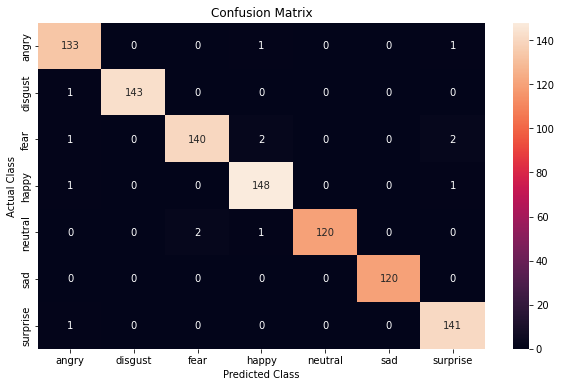

In [ ]:
# confusion_mtrx = tf.math.confusion_matrix(target_test_oh, elm_result)

plt.figure(figsize=(10, 6))
sns.heatmap(confusion, annot=True, 
            fmt='g',
            xticklabels=val_ds.class_names,
            yticklabels=val_ds.class_names
            )
plt.title('Confusion Matrix')
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
plt.show()

In [ ]:
from sklearn.metrics import precision_recall_fscore_support
precision, recall, fscore, support = precision_recall_fscore_support(test_labels, elm_result_class)

In [ ]:
print(precision)
print(recall)
print(fscore)
print(support)

[0.95833333 0.98648649 0.95890411 0.97435897 0.99212598 0.96923077
 0.96644295]
[0.9787234  0.97986577 0.96551724 0.96815287 0.94029851 0.984375
 0.98630137]
[0.96842105 0.98316498 0.96219931 0.97124601 0.96551724 0.97674419
 0.97627119]
[141 149 145 157 134 128 146]


In [ ]:
from sklearn.metrics import accuracy_score

print('Accuracy: ', accuracy_score(test_labels, elm_result_class))

Accuracy:  0.972


In [ ]:
# classification report
from sklearn.metrics import classification_report
print(classification_report(test_labels, elm_result_class))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       141
           1       0.99      0.98      0.98       149
           2       0.96      0.97      0.96       145
           3       0.97      0.97      0.97       157
           4       0.99      0.94      0.97       134
           5       0.97      0.98      0.98       128
           6       0.97      0.99      0.98       146

    accuracy                           0.97      1000
   macro avg       0.97      0.97      0.97      1000
weighted avg       0.97      0.97      0.97      1000



**PREDICT (1 DATA)**

In [ ]:
for images, labels in val_ds.take(1):
  predictions = elm_model.predict(images)

AttributeError: ignored

In [ ]:
print(np.argmax(predictions[10]))

In [ ]:
#Check actual emotion/class
plt.figure(figsize=(10, 10))
for images, labels in val_ds.take(1):
    plt.imshow(images[10].numpy().astype("uint8"))
    plt.title(val_ds.class_names[labels[10]])
    plt.axis("off")

In [ ]:
# import plotly
# import plotly.figure_factory as ff
#  # Confusion Matrix Plot
# trace = ff.create_annotated_heatmap(z=confusion, colorscale=[[0, '#E6E6E6'], [1, '#04B486']])
# for i in range(len(trace.layout.annotations)):
#     trace.layout.annotations[i].font.size = 20
# plotly.offline.plot(trace, filename="plot_result.html")